In [1]:
pred_lapse=4
window_size = 52

In [2]:
%pip install yfinance
%pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Our target is to predict next 4th week close using current data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importing data

In [4]:
import yfinance as yf
import datetime

start_date = datetime.date(2020,1, 1)
end_date = datetime.date.today()

ticker = "RELIANCE.NS"
data = yf.download(ticker, start=start_date,interval='1wk',
                      end=end_date, progress=False)
# data = data.resample("W").agg({"Open": "first", "High": "max", "Low": "min", "Close": "last"})
data['4th Close']=data['Close'].shift(-pred_lapse)
data=data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,4th Close
Date,,,,,,,
2019-12-30,1503.745972,1527.173950,1491.363403,1522.716187,1507.616455,24320802,1370.360352
2020-01-06,1505.727173,1543.320801,1483.933838,1533.117554,1517.914795,39094482,1420.187988
2020-01-13,1530.541992,1570.067383,1503.993652,1566.154419,1550.623901,42563308,1473.631470
2020-01-20,1593.891479,1593.891479,1504.290771,1507.262695,1492.316162,40458568,1471.996948
2020-01-27,1500.675049,1510.135376,1358.225342,1370.360352,1356.771484,66424087,1316.173950


Taking data in weekly timeframe
The reason why we are converting to weekly timeframe is that higher the timeframe, lower is the noise and hence increases predictability of the model. 

In [5]:
data_train,data_test=train_test_split(data.copy(),test_size=0.33,shuffle=False)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from pmdarima.arima import AutoARIMA
from pmdarima.arima import ARIMA
from pmdarima.pipeline import Pipeline as arPipeline
from pmdarima.arima import auto_arima
from pmdarima.preprocessing import LogEndogTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

getting parameters of arima model

In [7]:
auto = auto_arima(data_train['4th Close'], stepwise=False,seasonal=True,max_d=5,max_p=window_size,
                     suppress_warnings=True, error_action="ignore", trace=True,max_P=10,max_D=10,max_Q=10)
print(auto.order)
print(auto.seasonal_order)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1330.456, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1332.271, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1333.681, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1335.665, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1337.536, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1339.538, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1332.249, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1334.015, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1335.645, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1337.646, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1339.536, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1333.674, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1335.646, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1337.645, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1339.585, Time=1.02 sec
 ARIMA(3,1

adding values predicted by ARIMA to X_train to train SVM on this

In [8]:
df=data_train.copy()
df['arima']=pd.NA
total = len(df)
step = 1
model = arPipeline([ ('log',LogEndogTransformer()), ('ar',ARIMA(order=auto.order,seasonal_order=auto.seasonal_order,suppress_warnings=True))])  # Specify the appropriate order for the ARIMA model p,d,q
for i in range(window_size, total):
    train_data = df['Close'].iloc[i-window_size:i]  # Get the current window of data
    model.fit(train_data)
    next_observation = model.predict(pred_lapse)  # Forecast the next observation
    df.iloc[i,df.columns.get_loc('arima')]=next_observation[-1]
newdf=df.dropna()
print(newdf['arima'])
mean_absolute_percentage_error(newdf['arima'],newdf['4th Close'])*100


Date
2020-12-28     2036.78177
2021-01-04    2028.377133
2021-01-11     1965.93561
2021-01-18    1975.981027
2021-01-25    2115.345971
                 ...     
2022-02-07     2355.68911
2022-02-14    2401.332713
2022-02-21    2453.170485
2022-02-28    2292.415867
2022-03-07    2340.971087
Name: arima, Length: 63, dtype: object


7.076458069921621

Trying out an SVM without parameter optimization

In [9]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
svm_features=['Open','High','Low','Close','arima','Volume']
model2=make_pipeline(StandardScaler(),SVR(kernel='rbf'))
X=newdf.drop('4th Close',axis=1)
y=newdf['4th Close']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=False)
model2.fit(X_train,y_train)
pred=model2.predict(X_test)
print(mean_absolute_percentage_error(pred,y_test)*100)

13.484499899606813


define a fitness function for CSO to optimize

In [10]:
def fit_svr(X):
    X.reshape(-1)
    logC,epsilon=X
    model=make_pipeline(StandardScaler(),SVR(C=10**logC,epsilon=epsilon,kernel='rbf'))
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    return mean_absolute_percentage_error(pred,y_test)*100

parameter optimization

In [11]:
from cuckoo_discrete import CSO
svr_cso=CSO(fit_svr,n=2,bound=[(0,4),(0.05,10)],P=20,Tmax=10)

In [12]:
svr_cso.execute()


OPTIMUM SOLUTION
  > [2.5085728, 0.05]

OPTIMUM FITNESS
  > 4.9710034



Making setup for final predictions


In [13]:
X_test=data_test.drop('4th Close',axis=1)
X_test['arima']=pd.NA
y_new=data_test['Close']
y_base=data_train['Close'].iloc[-99:]
y_arima=pd.concat([y_base,y_new])
predictions=pd.DataFrame(index=X_test.index,columns=['arima','svm-arima'])
logC,epsilon=svr_cso.best

In [14]:
print(y_arima.shape)
len(X_test)

(157,)


58

predicting on whole data

In [15]:
n=len(data_test)
df=pd.concat([data_train.iloc[-window_size:],data_test])
predictions=pd.DataFrame(columns=['actual','arima-svm','arima'],index=df.index)
X=df.drop('4th Close',axis=1).copy()
X['arima']=pd.NA
y=df['4th Close'].copy()

arima_model = ARIMA(order=auto.order, seasonal_order=auto.seasonal_order, suppress_warnings=True)  # Specify the appropriate order for the ARIMA model p, d, q
arima_model.fit(X.iloc[0:window_size,X.columns.get_loc('Close')])
X.iloc[0:window_size,X.columns.get_loc('arima')]=arima_model.predict_in_sample()

tscv=TimeSeriesSplit(n_splits=n,max_train_size=window_size,test_size=1,gap=0)
# print(X.head(10))
for train_index,test_index in tscv.split(df.index):
#     print(train_index,test_index)
    X_train,y_train=X.iloc[train_index],y.iloc[train_index]
    X_test,y_test=X.iloc[test_index],y.iloc[test_index]
    arima_model = ARIMA(order=auto.order, seasonal_order=(0, 0, 0, 0), suppress_warnings=True)  # Specify the appropriate order for the ARIMA model p, d, q
    
    y_arima=pd.concat([X_train['Close'],X_test['Close']])
    arima_model.fit(X_train['Close'])
    arima_preds=arima_model.predict(pred_lapse)
    arima_prediction=arima_preds[-1]
    X.iloc[test_index[-1],X.columns.get_loc('arima')]=arima_prediction
#     print(arima_prediction)
    predictions.iloc[test_index[-1],predictions.columns.get_loc('arima')]=arima_prediction
    X_test,y_test=X.iloc[test_index],y.iloc[test_index]
    svm_model=make_pipeline(StandardScaler(),SVR(C=10**logC,epsilon=epsilon,kernel='rbf'))
    svm_model.fit(X_train,y_train)
#     print(X_test)
    svm_prediction=svm_model.predict(X_test)
    predictions.iloc[test_index[-1],predictions.columns.get_loc('arima-svm')]=svm_prediction[0]
    predictions.iloc[test_index[-1],predictions.columns.get_loc('actual')]=y_test.values[0]
    
    

predictions=predictions.dropna()


WINDOW SIZE: 52
ARIMA RMSE: 168.08559803919005
ARIMA-SVM RMSE: 149.06446729154706
ARIMA MAE: 142.0921852880431
ARIMA-SVM MAE: 116.45389519916564
ARIMA MAPE: 5.729163651067001
ARIMA-SVM MAPE: 4.673524232483747


Text(0.5, 1.0, 'RELIANCE.NS next month predictions')

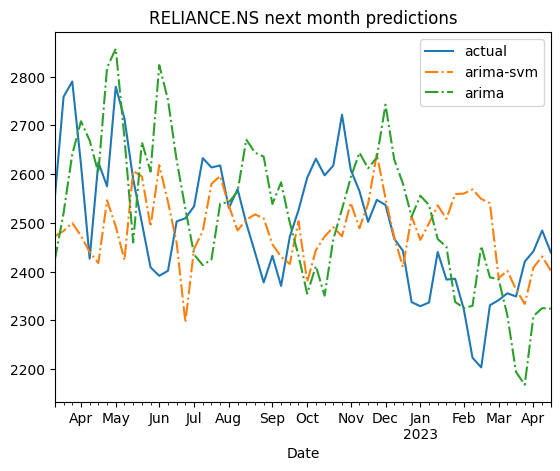

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE
arima_rmse = mean_squared_error(predictions['arima'], predictions['actual'], squared=False)
arima_svm_rmse = mean_squared_error(predictions['arima-svm'], predictions['actual'], squared=False)

# Calculate MAE
arima_mae = mean_absolute_error(predictions['arima'], predictions['actual'])
arima_svm_mae = mean_absolute_error(predictions['arima-svm'], predictions['actual'])

# Calculate MAPE
arima_mape = np.mean(np.abs((predictions['actual'] - predictions['arima']) / predictions['actual'])) * 100
arima_svm_mape = np.mean(np.abs((predictions['actual'] - predictions['arima-svm']) / predictions['actual'])) * 100

# Print evaluation metrics
print("WINDOW SIZE:",window_size)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA-SVM RMSE:", arima_svm_rmse)
print("ARIMA MAE:", arima_mae)
print("ARIMA-SVM MAE:", arima_svm_mae)
print("ARIMA MAPE:", arima_mape)
print("ARIMA-SVM MAPE:", arima_svm_mape)

# Set plot title
predictions.plot(style=['','-.','-.'])
plt.title(ticker+' next month predictions')


In [17]:
len(predictions)
len(data_test)

58